In [41]:
#import necessary libraries for regression analysis
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

### Custom Functions ###

In [77]:
def create_ols (df, target = 'price'):
    
    """Inputs: 
    df = data as data frame
    target : str = name of target variable
    
    
    Retruns: an sm.OLS model
    Prints out the summary table
    ------------------------
    """ 
    
    
    X = df.drop(target, axis=1)
    model = ols(formula='price~' + '+'.join(X.columns), data=df).fit()
    print(model.summary())
    return model

################


def test_homoskedasticity(model):
    
    """Input: 
    model: an sm.OLS model  
    
    Retrun: 
    True if 
    False  
    Prints out P-value and F-statistic
    ------------------------
    Uses the Breusch–Pagan test. If p-value is below 0.05, then 
    the null hypothesis of homoskedasticity is rejected and 
    heteroskedasticity is assumed.
    """ 

    _, pval, _, f_pval = diag.het_breuschpagan(model.resid, model.model.exog)
    
    print('-'*50)
    print('The P-value is: {:.2}'.format(pval))
    print('The F-statistic is {:.2}'.format(f_pval))
    print('-'*50)
    
    if pval >= 0.05:
        return True
    
    return False

################

def test_resid_distribution(model):
    """Input --> model: an sm.OLS model  
    
    Retruns: nothing
    Displays a Q-Q-Plot
    Prints out the Mean of the Residuals.
    ------------------------
    This function check for normality of the residuals with a Q-Q-Plot 
    and verifies by displaying the mean of the residuals. The closer the mean is 
    to 0, the more normal the distribution of the residuals. 
    """ 
    import pylab
    sm.qqplot(model.resid, line = 's')
    pylab.show()
    
    mean_residuals = sum(model.resid)/len(model.resid)

    print('The mean of the residuals is: {:.2}. The closer to 0, the better.'.format(mean_residuals))

################

def test_features_vif(df, target="",):
    """Input:
    df = data as data frame
    target : str = name of target variable
    
    Retruns: a list of features with a high variance inflation factor
    Displays a data frame with the VIFs for each feature
    
    ------------------------
    """ 
    
    X = df.drop(target, axis=1)
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    display(vif.round(1))
    
    corr_features = list(vif[vif["VIF Factor"] > 30]['features'])
    return corr_features

###########

def get_low_pval_features(model):
    """Input -- > model - an OLS model
    
    Retruns: a list of features with p-value < 0.05 
    in the summary table
    
    ------------------------
    """ 
    
    summary = model.summary()
    ptable = summary.tables[1]
    df_p = pd.DataFrame(ptable.data)
    df_p.drop(0, inplace=True)
    df_p[4] = df_p[4].map(lambda x: float(x))
    relevant_list = list(df_p[df_p[4] < .05][0][1:])
    
    return relevant_list


In [2]:
df_preprocessed = pd.read_csv('Project2datacleaned', index_col=0)
df_preprocessed.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,...,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,condition_2,condition_3,condition_4,condition_5
0,221900.0,3,1.00,1180,5650,0.0,1180,0.0,1955,0.0,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,3,2.25,2570,7242,0.0,2170,400.0,1951,1991.0,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,2,1.00,770,10000,0.0,770,0.0,1933,0.0,...,0,0,0,0,0,0,0,1,0,0
3,604000.0,4,3.00,1960,5000,0.0,1050,910.0,1965,0.0,...,0,0,0,0,0,0,0,0,0,1
4,510000.0,3,2.00,1680,8080,0.0,1680,0.0,1987,0.0,...,1,0,0,0,0,0,0,1,0,0


### Train-Test-Split

In [3]:
train, test = train_test_split(df_preprocessed, test_size=0.2, random_state=42)

In [4]:
print(len(train), len(test))

17136 4284


In [5]:
#Build baseline model
X = train.drop('price', axis=1)
formula = 'price~' + '+'.join(X.columns)

In [6]:
baseline = ols(formula=formula, data=train).fit()

In [7]:
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1047.
Date:                Tue, 17 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:11:08   Log-Likelihood:            -2.3415e+05
No. Observations:               17136   AIC:                         4.684e+05
Df Residuals:                   17099   BIC:                         4.687e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.048e+07   3.41e+06      3.074      0.002     3.8e+06    1.72e+07
bedrooms      -2.355e+04   2248.807    -10.474      0.000    -2.8e+04   -1.91e+04
bathrooms      4.796e+04   3806.396     12.600      0.000    4.05e+04    5.54e+04
sqft_living     113.3244     20.713      5.471      0.000      72.725     153.924
sqft_lot          0.0426      0.064      0.663      0.507      -0.083       0.169
waterfront     5.288e+05   2.32e+04     22.762      0.000    4.83e+05    5.74e+05
sqft_above        4.5005     20.777      0.217      0.829     -36.224      45.225
sqft_basement    29.9848     20.544      1.460      0.144     -10.283      70.253
yr_built      -3142.8820     88.513    -35.508      0.000   -3316.376   -2969.387
yr_renovated      9.2340      6.106      1.512      0.130      -2.734      21.202
zipcode         -45.3147     34.187     -1.325      0.185    -112.325      21.696
sqft_living15    36.3798      4.005      9.083      0.000      28.529      44.230
sqft_lot15       -0.6426      0.095     -6.760      0.000      -0.829      -0.456
renovated      5.109e+04   1.11e+04      4.618      0.000    2.94e+04    7.28e+04
floors_1_5     9747.4696   6331.305      1.540      0.124   -2662.540    2.22e+04
floors_2_0     1.502e+04   5116.880      2.936      0.003    4994.575    2.51e+04
floors_2_5     1.583e+05   1.91e+04      8.299      0.000    1.21e+05    1.96e+05
floors_3_0     1.353e+05    1.1e+04     12.278      0.000    1.14e+05    1.57e+05
floors_3_5     3.133e+05   1.04e+05      3.000      0.003    1.09e+05    5.18e+05
view_1_0       1.143e+05   1.31e+04      8.747      0.000    8.87e+04     1.4e+05
view_2_0       4.893e+04   8048.032      6.080      0.000    3.32e+04    6.47e+04
view_3_0       1.023e+05    1.1e+04      9.323      0.000    8.08e+04    1.24e+05
view_4_0       2.202e+05   1.66e+04     13.271      0.000    1.88e+05    2.53e+05
grade_4        7348.5874   2.14e+05      0.034      0.973   -4.12e+05    4.26e+05
grade_5        1.916e+04   2.09e+05      0.092      0.927    -3.9e+05    4.29e+05
grade_6        7.801e+04   2.08e+05      0.374      0.708   -3.31e+05    4.87e+05
grade_7        1.565e+05   2.08e+05      0.751      0.453   -2.52e+05    5.65e+05
grade_8        2.371e+05   2.08e+05      1.137      0.255   -1.72e+05    6.46e+05
grade_9        3.781e+05   2.09e+05      1.813      0.070   -3.07e+04    7.87e+05
grade_10       5.461e+05   2.09e+05      2.617      0.009    1.37e+05    9.55e+05
grade_11       8.303e+05   2.09e+05      3.972      0.000    4.21e+05    1.24e+06
grade_12       1.291e+06    2.1e+05      6.143      0.000    8.79e+05     1.7e+06
grade_13       2.589e+06   2.18e+05     11.878      0.000    2.16e+06    3.02e+06
condition_2    7.746e+04   4.58e+04      1.690      0.091   -1.24e+04    1.67e+05
condition_3    8.977e+04   4.21e+04      2.134   

In [49]:
baseline_test = create_ols(train,target='price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1047.
Date:                Tue, 17 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:28:19   Log-Likelihood:            -2.3415e+05
No. Observations:               17136   AIC:                         4.684e+05
Df Residuals:                   17099   BIC:                         4.687e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.048e+07   3.41e+06      3.074

In [50]:
test_homoskedasticity(baseline_test)

--------------------------------------------------
The P-value is: 0.0
The F-statistic is 0.0
--------------------------------------------------


False

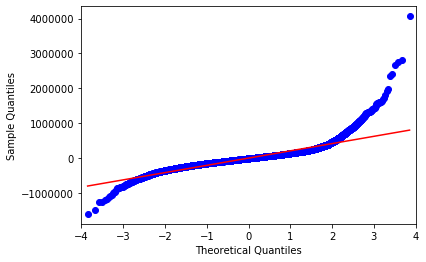

The mean of the residuals is: 9.7e-07. The closer to 0, the better.


In [52]:
test_resid_distribution(baseline_test)

In [54]:
check_vif(baseline_test)

3.2044203703893275

In [66]:
test_features_vif(train,'price')

,VIF Factor,features
0,24.5,bedrooms
1,29.2,bathrooms
2,884.8,sqft_living
3,2.9,sqft_lot
4,1.5,waterfront
5,668.9,sqft_above
6,46.2,sqft_basement
7,10819.0,yr_built
8,2.0,yr_renovated
9,27332.8,zipcode


['sqft_living',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'zipcode',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'condition_3',
 'condition_4',
 'condition_5']

In [78]:
get_low_pval_features(baseline_test)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'waterfront',
 'yr_built',
 'sqft_living15',
 'sqft_lot15',
 'renovated',
 'floors_2_0',
 'floors_2_5',
 'floors_3_0',
 'floors_3_5',
 'view_1_0',
 'view_2_0',
 'view_3_0',
 'view_4_0',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'condition_3',
 'condition_4',
 'condition_5']